Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8096584..2.2391288].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565..2.3785625].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.4831376].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9656862..1.5639181].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.5005665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7906162..2.

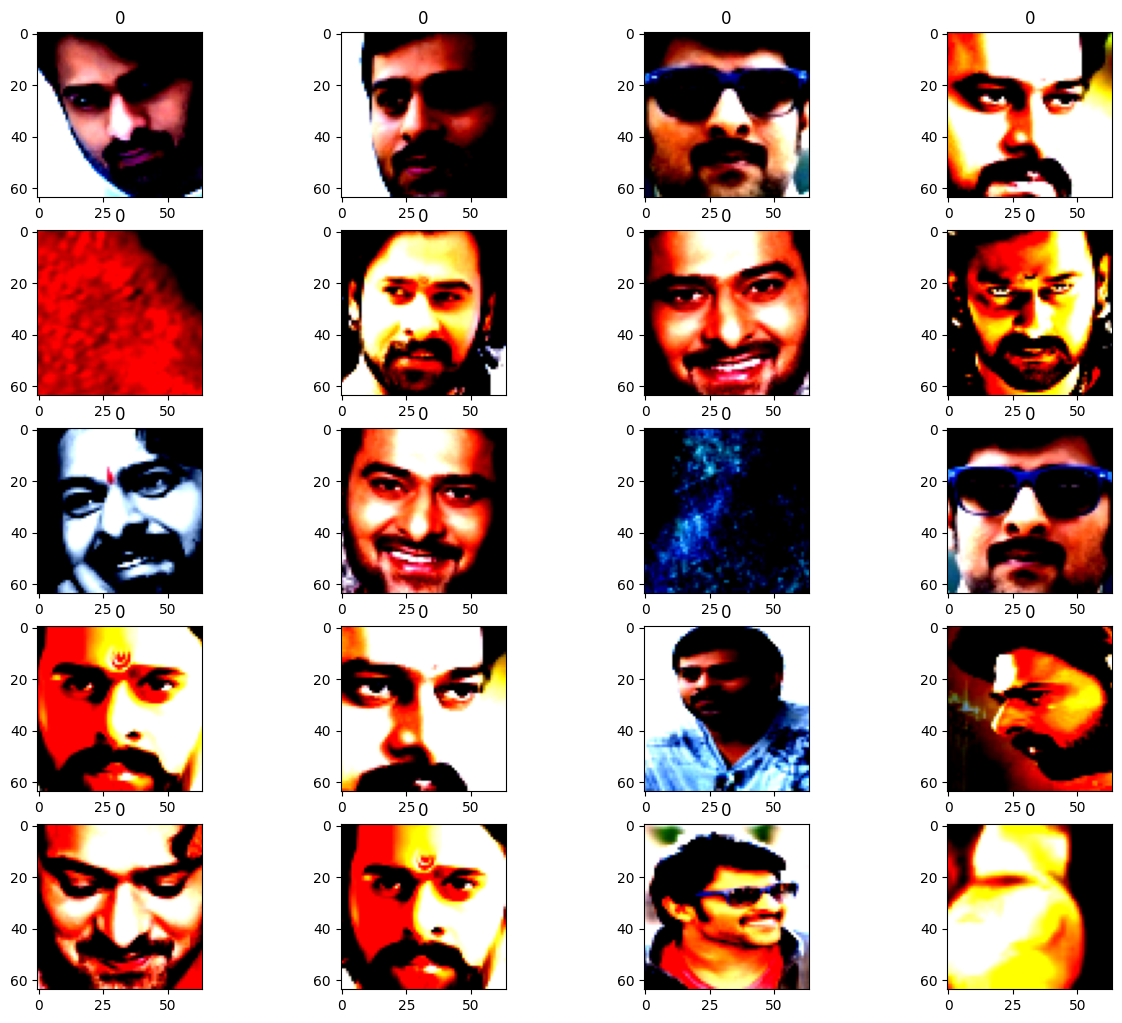

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
from torch import nn
import numpy as np
import math

# Define transformations
IMG_SIZE = 64
data_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.image_paths = []
        self.labels = []
        for label, cls in enumerate(self.classes):
            cls_path = os.path.join(root_dir, cls)
            for img in os.listdir(cls_path):
                if os.path.isfile(os.path.join(cls_path, img)):
                    self.image_paths.append(os.path.join(cls_path, img))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Define your dataset path
root_dir = 'dataset_new_diff'  # Replace with your actual dataset path

# Load the custom dataset
custom_dataset = CustomDataset(root_dir=root_dir, transform=data_transforms)
dataloader = DataLoader(custom_dataset, batch_size=32, shuffle=True)

# Function to show some images from the dataset
def show_images(dataset, num_samples=20, cols=4):
    plt.figure(figsize=(15,15))
    for i, (img, label) in enumerate(dataset):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img.permute(1, 2, 0))  # Convert CHW to HWC
        plt.title(label)

# Show some images from the custom dataset
show_images(custom_dataset)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Define beta schedule
T = 1000
betas = torch.linspace(0.0001, 0.02, T)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cuda:1"):
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t):
        h = self.bnorm1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        h = h + time_emb
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)

In [ ]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class SimpleUnet(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3
        time_emb_dim = 32

        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )

        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], time_emb_dim) for i in range(len(down_channels)-1)])
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True) for i in range(len(up_channels)-1)])
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

device = 'cuda:1'
model = SimpleUnet().to(device)
print("Num params: ", sum(p.numel() for p in model.parameters()))

Num params:  62438883


In [ ]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

def show_tensor_image(image):
    reverse_transform = transforms.Compose([
        transforms.Normalize(mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                             std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
        transforms.ToPILImage()
    ])
    image = reverse_transform(image.squeeze())
    plt.imshow(image)
    plt.axis('off')
    plt.show()

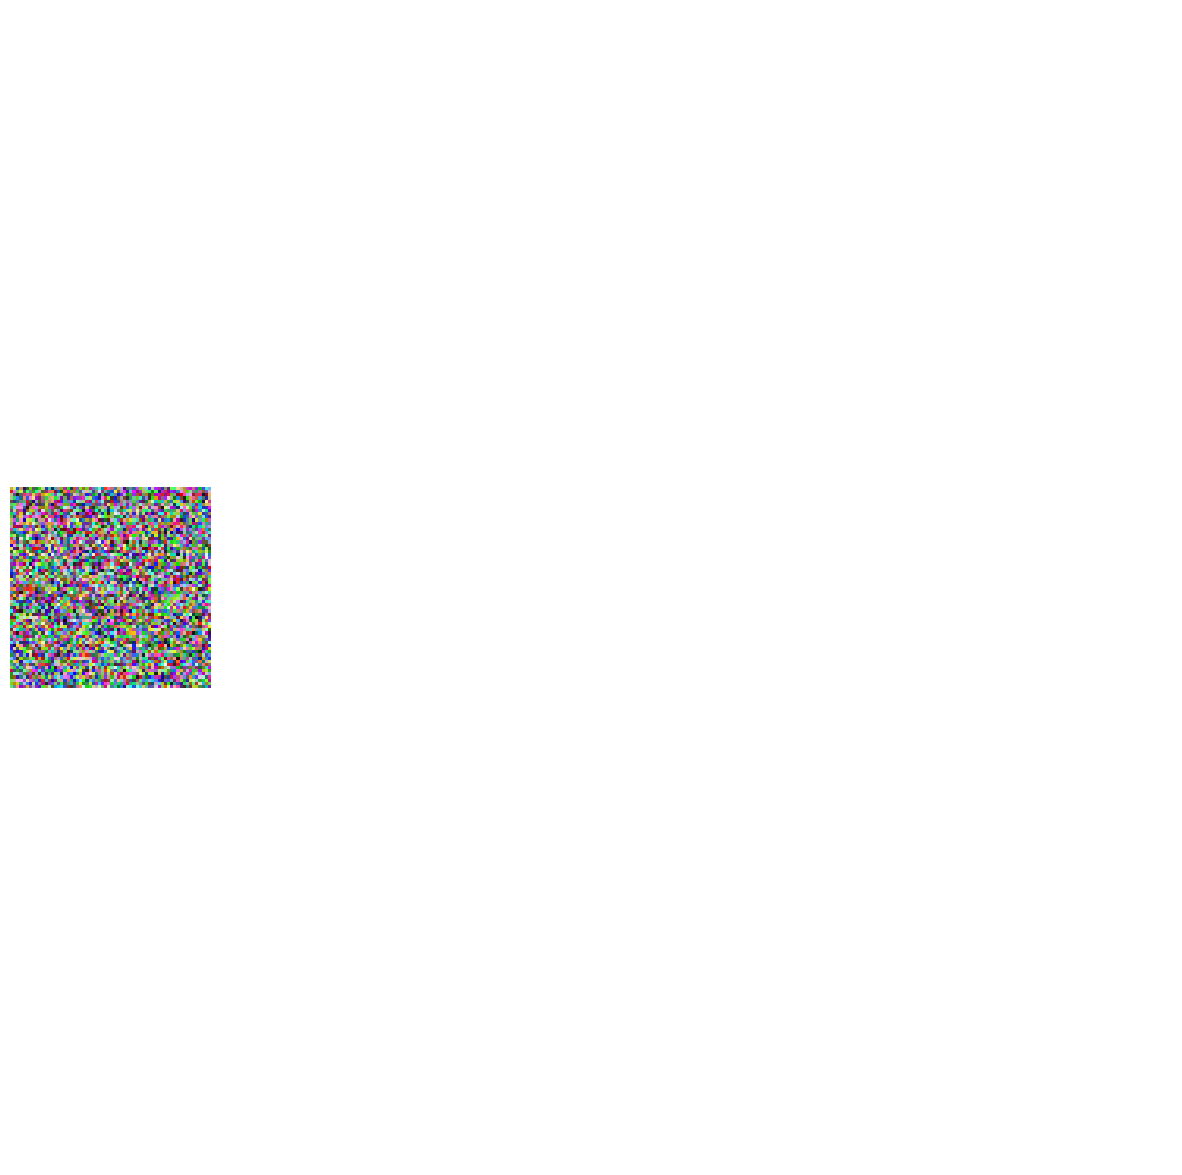

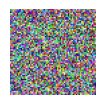

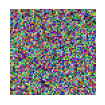

/home/student/2020/cs20btech11028/anaconda3/envs/diff/lib/python3.10/site-packages/torchvision/transforms/functional.py:282: RuntimeWarning: invalid value encountered in cast
  npimg = (npimg * 255).astype(np.uint8)


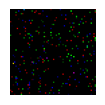

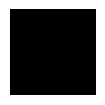

In [ ]:
# device = "cuda:1" if torch.cuda.is_available() else "cpu"
device = 'cuda:1'
@torch.no_grad()
def sample_timestep(x, t):
    betas_t = get_index_from_list(betas, t, x.shape)
    # print(betas_t.device)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x.shape)
    # print(sqrt_one_minus_alphas_cumprod_t.device)
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    # print(sqrt_recip_alphas_t.device)
    model_mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t)
    # print("hi", model_mean.device)
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    # Generate noise
    noise = torch.randn_like(x)

    # Check for each element if it's at timestep 0
    is_t_0 = t == 0

    # Where t is 0, return model_mean directly, else add noise
    result = torch.where(is_t_0.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1), model_mean, model_mean + torch.sqrt(posterior_variance_t) * noise)

    return result

@torch.no_grad()
def sample_plot_image(category, num_images=1):
    img_size = IMG_SIZE
    img = torch.randn((num_images, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')

    category_idx = custom_dataset.classes.index(category)
    t = torch.tensor([category_idx] * num_images, device=device)

    for i in range(num_images):
        for timestep in reversed(range(T)):
            # print(torch.full((num_images,), timestep, device=device, dtype=torch.long).device)
            img = sample_timestep(img, torch.full((num_images,), timestep, device=device, dtype=torch.long))
        plt.subplot(1, num_images, i + 1)
        show_tensor_image(img[i])
    plt.show()

# Example usage to generate images of a specific category
sample_plot_image("mahesh_babu", num_images=5)  # Replace "Prabha

In [ ]:
# Training loop
device = "cuda:1" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 1000

for epoch in range(epochs):
    for i, (images, _) in enumerate(dataloader):
        optimizer.zero_grad()
        batch_size = images.shape[0]
        t = torch.randint(0, T, (batch_size,), device=device).long()
        loss = get_loss(model, images.to(device), t)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f"Epoch {epoch} Batch {i} Loss: {loss.item()}", end='\r')
            # sample_plot_image("mahesh_babu")

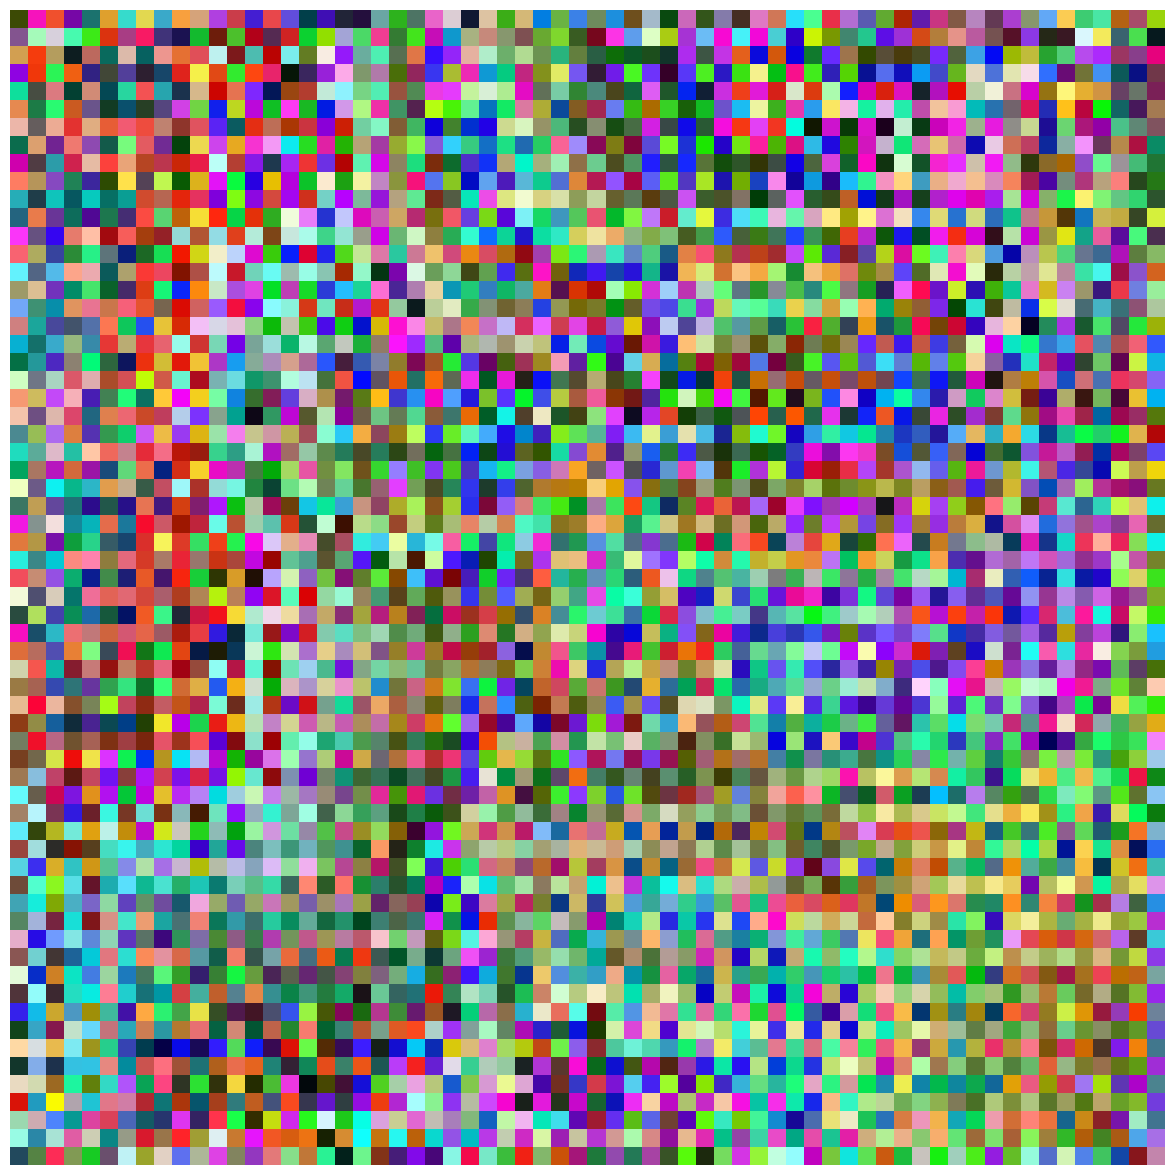

In [ ]:
sample_plot_image("mahesh_babu")

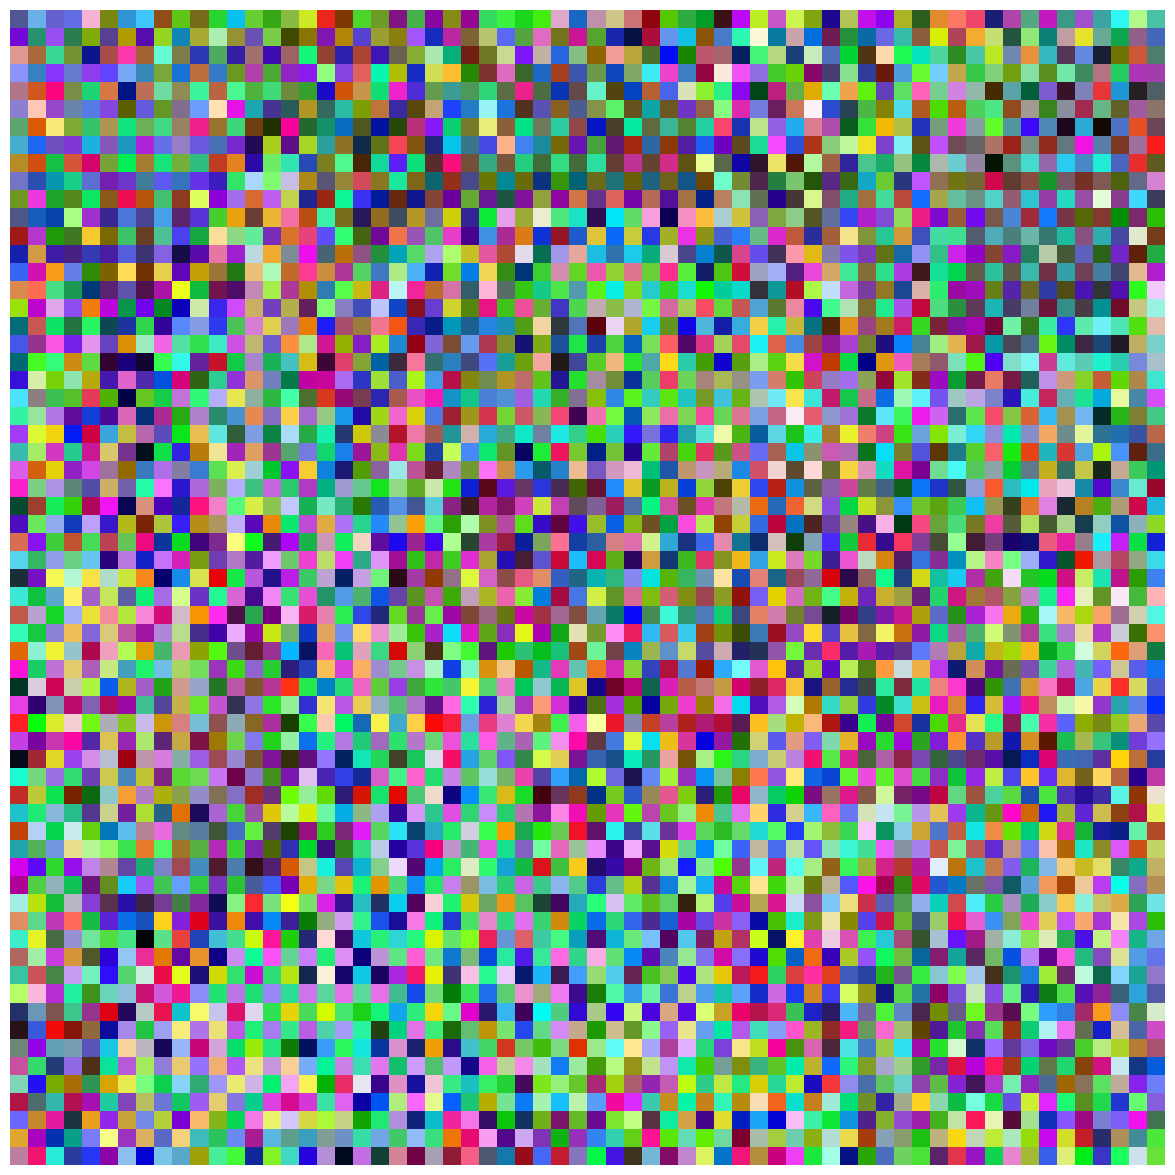

In [ ]:
sample_plot_image("prabhas")